In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from PIL import Image
from scipy.ndimage import generic_filter
import concurrent.futures


In [2]:
def show_cv2(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
def rescale_to_lower_resolution(image, scale_factor):
    new_width = int(image.shape[1] * scale_factor)
    new_height = int(image.shape[0] * scale_factor)
    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image

In [4]:
# image_path = '/home/andmin/Pictures/birb.jpg'
image_path = '/home/andmin/Pictures/sobol.jpg'
# image_path = '/home/andmin/Pictures/tmp.png'
img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
if img.shape[0] > 400:
    img = rescale_to_lower_resolution(img, 400/img.shape[0])
height, width = img.shape


## Original Image

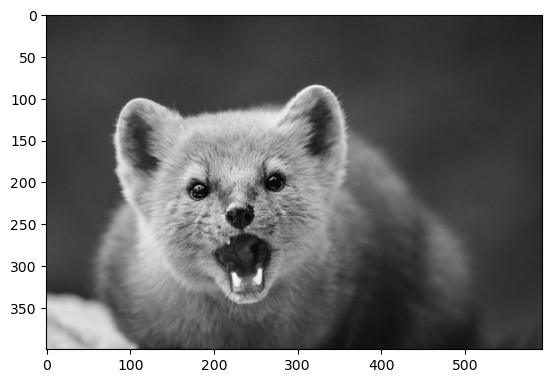

In [5]:
show_cv2(img)

# Correlation for searching template

### Random image part

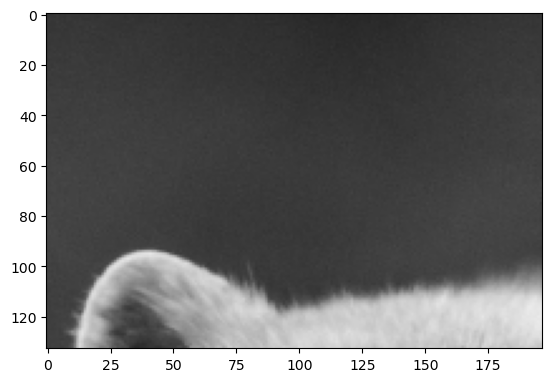

In [6]:
random_height = height // 3
random_width = width // 3

start_y = np.random.randint(0, height - random_height + 1)
start_x = np.random.randint(0, width - random_width + 1)

rpart = img[start_y:start_y + random_height, start_x:start_x + random_width]

show_cv2(rpart)

In [7]:
def correlation(image, template):
    image = (image - np.mean(image)) / np.std(image)
    template = (template - np.mean(template)) / np.std(template)

    result = np.zeros((image.shape[0] - template.shape[0] + 1, image.shape[1] - template.shape[1] + 1))
    template_height, template_width = template.shape

    def process_row(i):
        for j in range(result.shape[1]):
            roi = image[i:i + template_height, j:j + template_width]
            result[i, j] = np.sum(roi * template)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_row, i) for i in range(result.shape[0])]
        concurrent.futures.wait(futures)
    
    return result

## Correlation Map

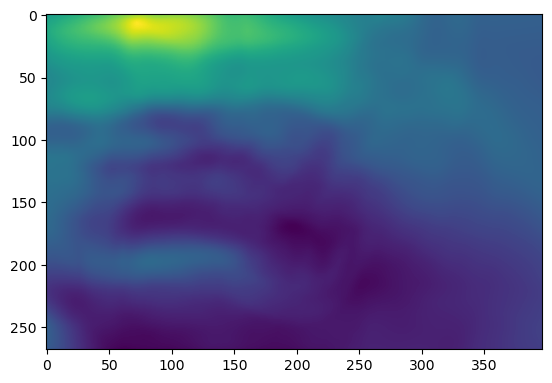

In [8]:
res = correlation(img, rpart)
plt.imshow(res)

## Found Image

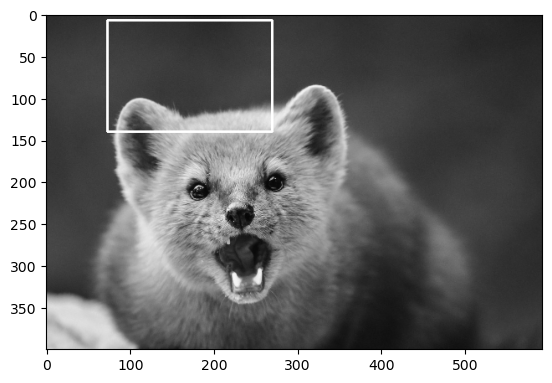

In [9]:
max_val = np.max(res)
max_loc = np.unravel_index(res.argmax(), res.shape)

rpart_height, rpart_width = rpart.shape[:2]

top_left = max_loc[::-1]
bottom_right = (top_left[0] + rpart_width, top_left[1] + rpart_height)

img_with_rectangle = img.copy()
cv2.rectangle(img_with_rectangle, top_left, bottom_right, 255, 2)

show_cv2(img_with_rectangle)
